In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy + Proballers Data

In [8]:
df1 = pd.read_csv('eurocup_offense_plus_pb.csv')
df1['league'] = 'EuroCup'
df2 = pd.read_csv('euroleague_offense_plus_pb.csv')
df2['league'] = 'EuroLeague'
df = pd.concat([df1, df2])
df.shape

(2444, 85)

In [9]:
mp_filter = df['Poss_est'] >= 300
df = df[mp_filter]
df.shape

(1658, 85)

In [10]:
df['avg_eff'] = df['Eff'] / df['GP_y']

In [11]:
def adjust_height(s):
    m, cm = s.split('m')
    return int(m) * 100 + int(cm) 

In [12]:
df['Height'] = df['Height'].apply(adjust_height)

In [13]:
df = df.reset_index(drop=True)

## Clustering

### Functions

In [14]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [15]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [16]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [17]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [18]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [19]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in EuroCup (2018-2022)')

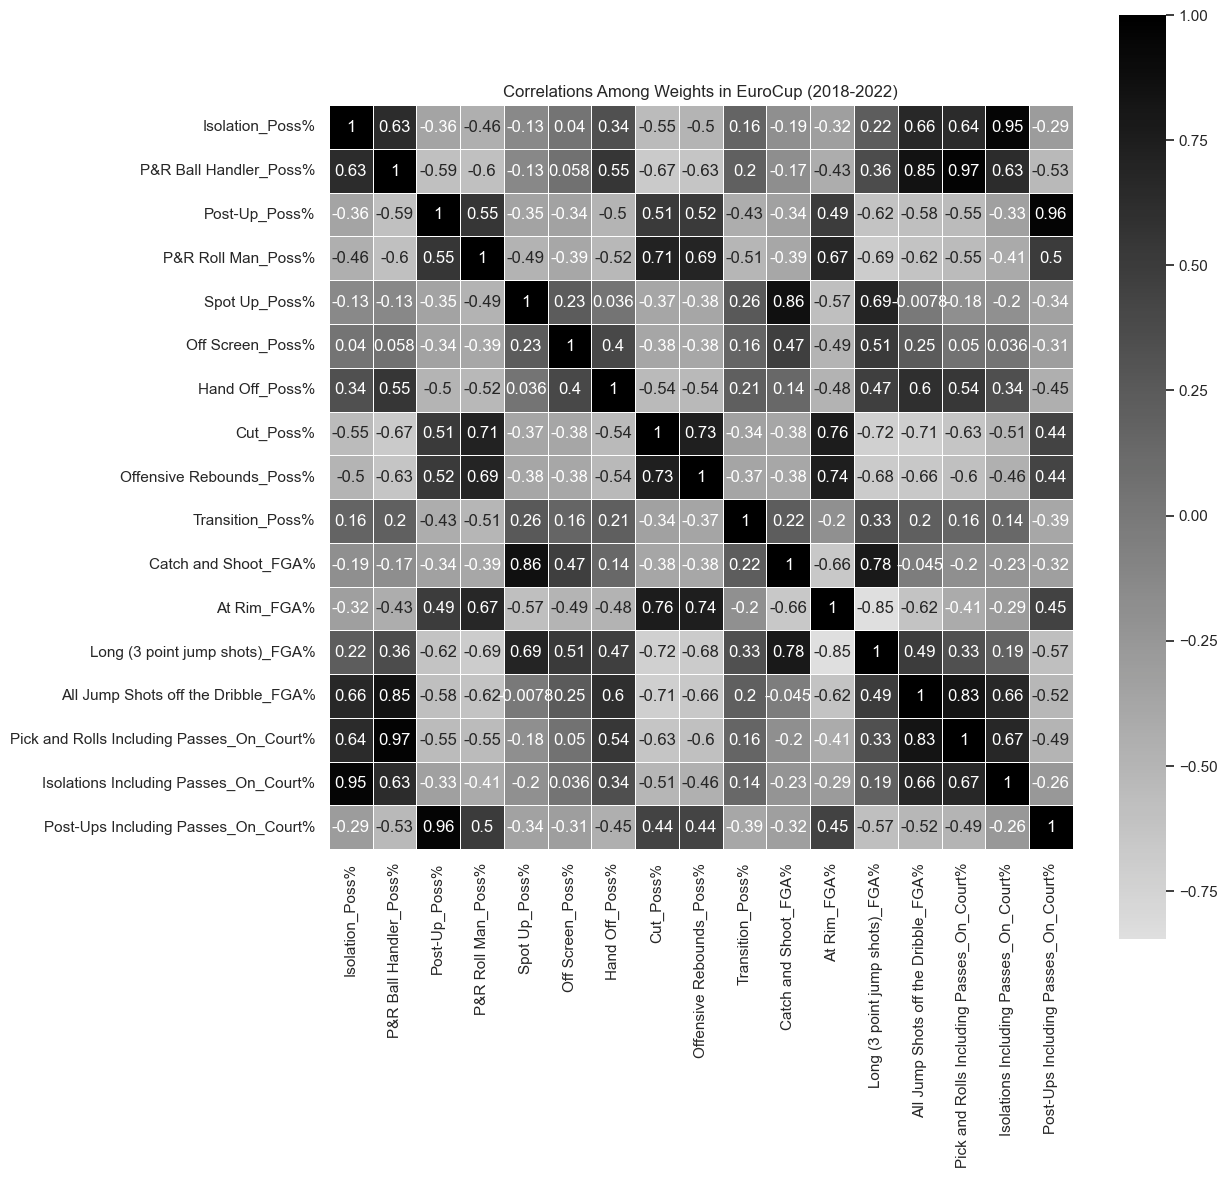

In [20]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in EuroCup (2018-2022)')

### Reduce Dimensions with PCA

In [21]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

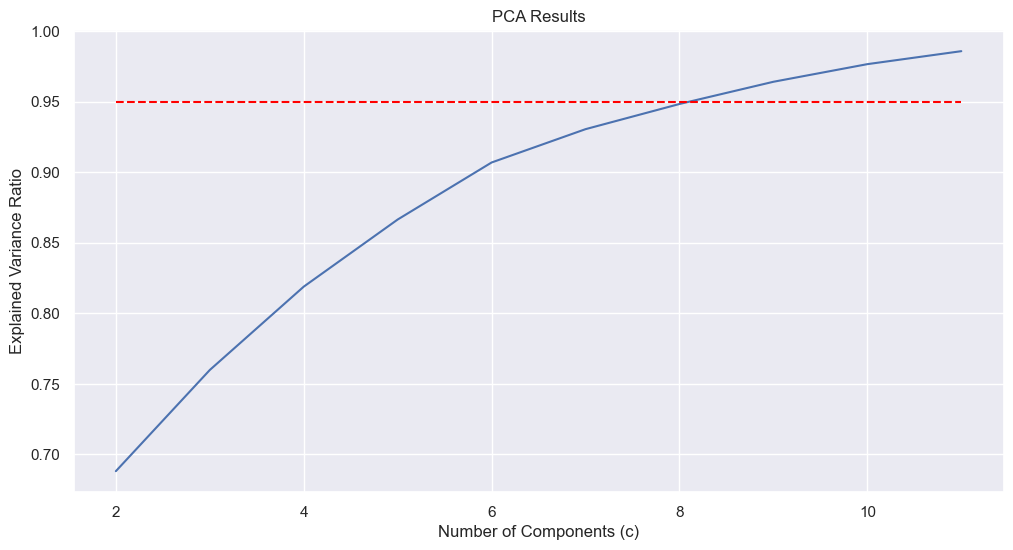

In [22]:
figsize(12, 6)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
# pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 9

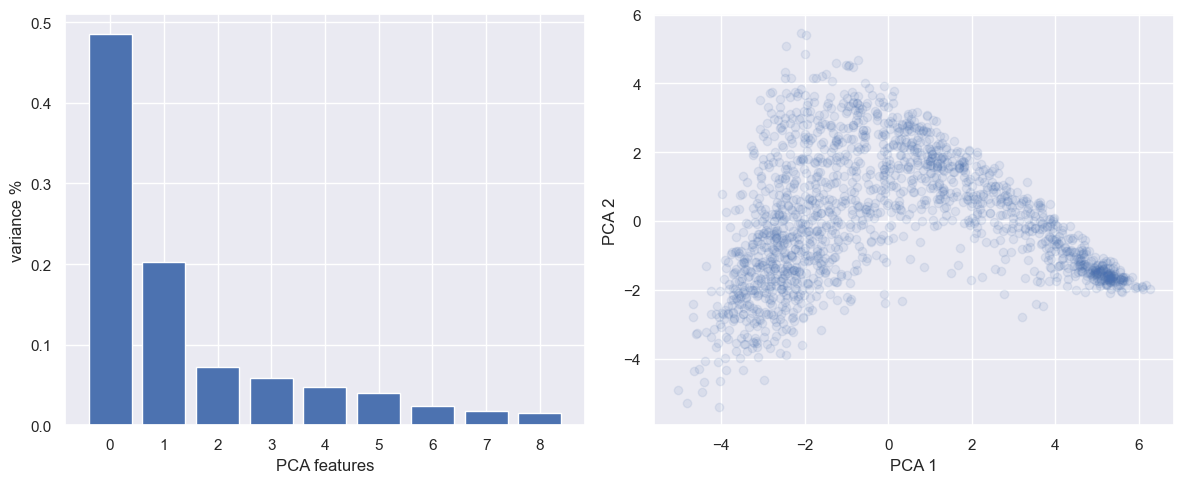

In [23]:
n_components = 9

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [24]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

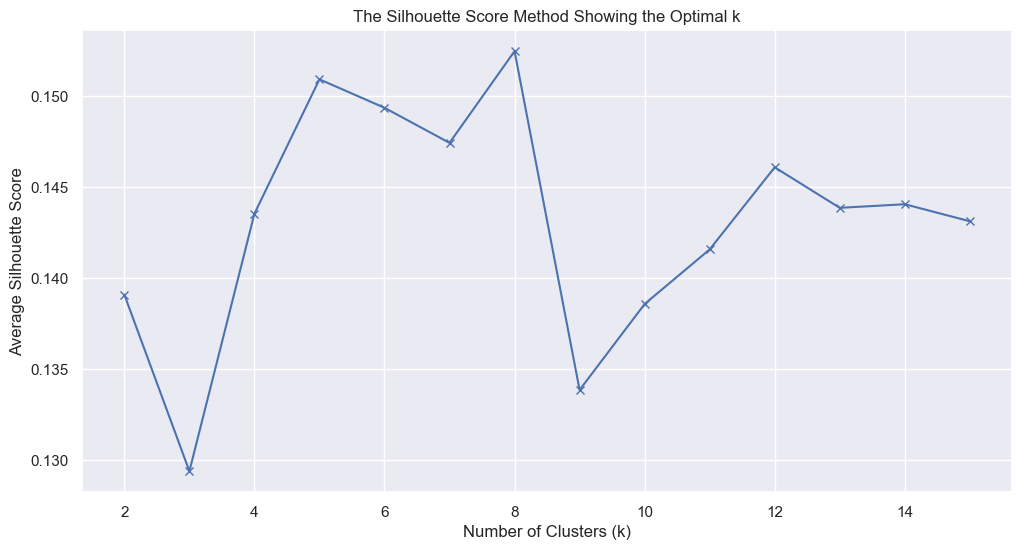

In [25]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [26]:
# Choose k = 8
n_clusters = 8

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    123
1    142
2    631
3     76
4    195
5     91
6     94
7    306
Name: Player, dtype: int64

## Results

### Functions

In [27]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [28]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['avg_eff'] + weights]\
                    .mean().sort_values('avg_eff', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['avg_eff'] = cluster_res['avg_eff'].apply(lambda x: f'{x:.2f}')
    for col in cluster_res.columns:
        if '%' in col or 'Rt' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [29]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6,7
player_cluster,6,0,3,4,7,1,2,5
avg_eff,11.62,11.53,10.02,9.94,8.93,8.76,8.15,7.62
Isolation_Poss%,1.90%,16.73%,0.50%,1.20%,7.60%,7.05%,3.57%,4.43%
P&R Ball Handler_Poss%,0.56%,36.42%,0.11%,0.20%,43.07%,29.98%,7.44%,14.92%
Post-Up_Poss%,33.59%,2.06%,18.52%,13.44%,0.80%,1.13%,8.51%,1.29%
P&R Roll Man_Poss%,19.46%,0.59%,23.80%,31.27%,0.10%,0.37%,5.22%,0.59%
Spot Up_Poss%,8.90%,19.03%,5.39%,11.26%,23.50%,26.22%,39.08%,31.99%
Off Screen_Poss%,1.15%,5.33%,0.18%,0.59%,4.42%,8.49%,4.97%,25.33%
Hand Off_Poss%,0.24%,3.76%,0.08%,0.12%,3.61%,9.36%,1.56%,3.93%
Cut_Poss%,17.01%,2.00%,21.32%,22.07%,2.47%,3.52%,9.46%,3.47%


- Ballhandler: 0 & 7 & 1
- Big: 6 & 3 & 4
- Wing: 2 & 5

In [30]:
cluster_dict = {0: 'Ballhandler', 7: 'Ballhandler', 1: 'Ballhandler',
                6: 'Big', 3: 'Big', 4: 'Big',
                2: 'Wing', 5: 'Wing'}

In [31]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [32]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [33]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5,6,7
player_cluster,6,0,3,4,7,1,2,5
avg_eff,11.62,11.53,10.02,9.94,8.93,8.76,8.15,7.62
Isolation_Poss%,1.90%,16.73%,0.50%,1.20%,7.60%,7.05%,3.57%,4.43%
P&R Ball Handler_Poss%,0.56%,36.42%,0.11%,0.20%,43.07%,29.98%,7.44%,14.92%
Post-Up_Poss%,33.59%,2.06%,18.52%,13.44%,0.80%,1.13%,8.51%,1.29%
P&R Roll Man_Poss%,19.46%,0.59%,23.80%,31.27%,0.10%,0.37%,5.22%,0.59%
Spot Up_Poss%,8.90%,19.03%,5.39%,11.26%,23.50%,26.22%,39.08%,31.99%
Off Screen_Poss%,1.15%,5.33%,0.18%,0.59%,4.42%,8.49%,4.97%,25.33%
Hand Off_Poss%,0.24%,3.76%,0.08%,0.12%,3.61%,9.36%,1.56%,3.93%
Cut_Poss%,17.01%,2.00%,21.32%,22.07%,2.47%,3.52%,9.46%,3.47%


### Observations

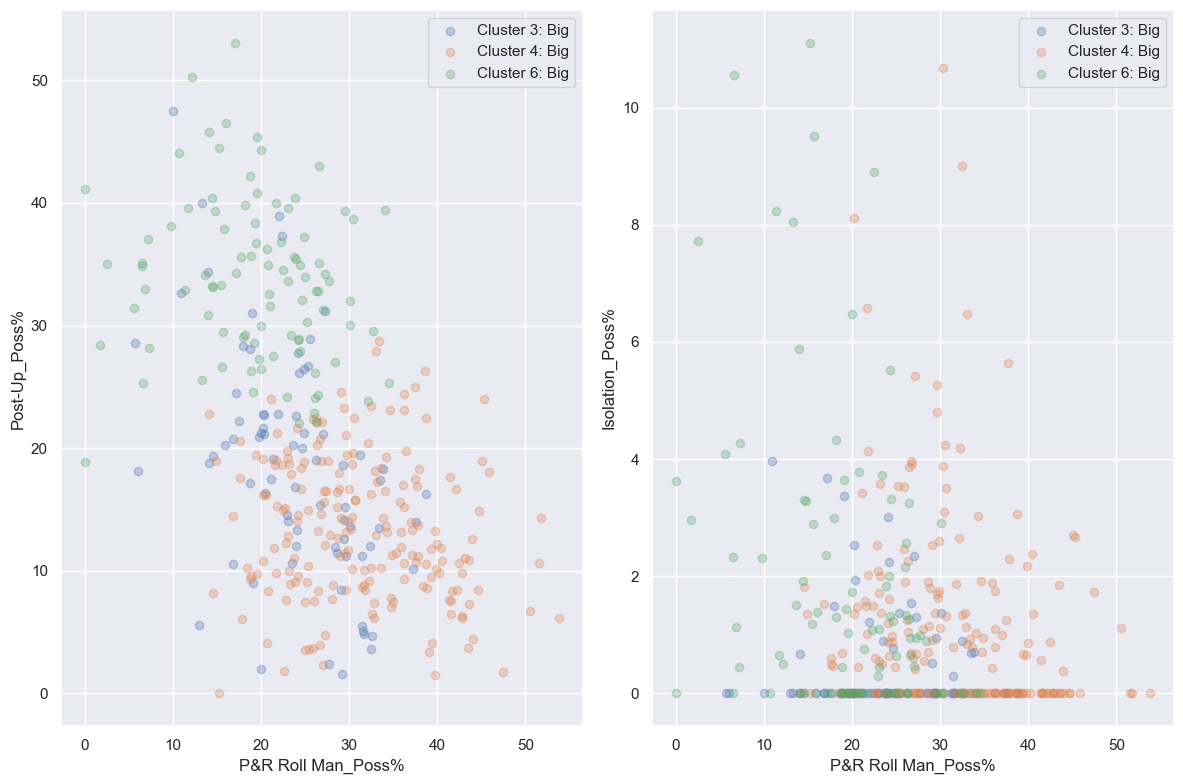

In [34]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

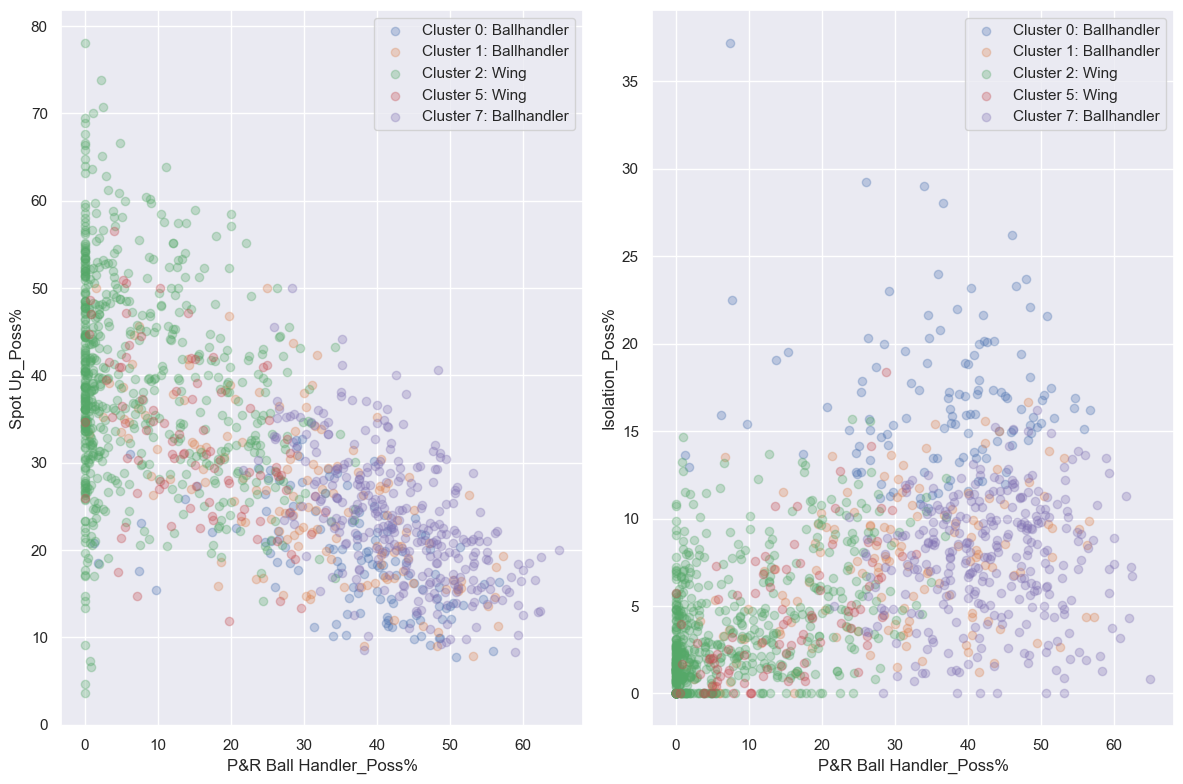

In [35]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

### Distributions

In [36]:
cluster_dict

{0: 'Ballhandler',
 7: 'Ballhandler',
 1: 'Ballhandler',
 6: 'Big',
 3: 'Big',
 4: 'Big',
 2: 'Wing',
 5: 'Wing'}

In [37]:
cluster_order = [7, 0, 1, 5, 2, 4, 6, 3]

Height & EFF

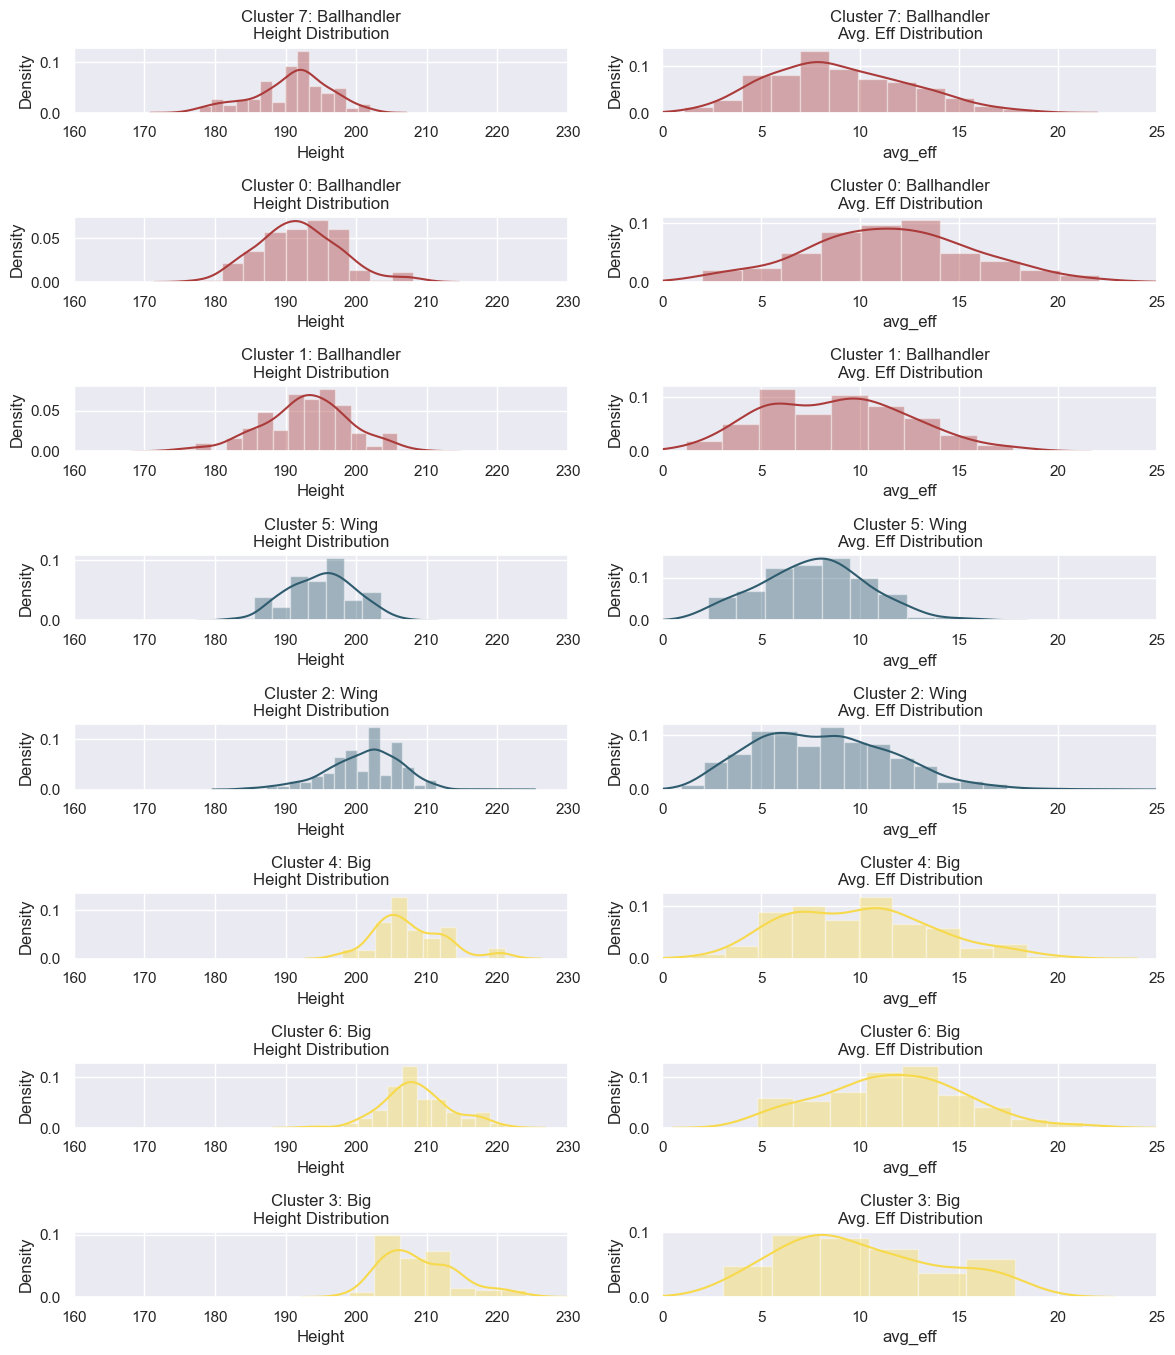

In [38]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['Height'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['avg_eff'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nAvg. Eff Distribution')
    plt.xlim(0, 25)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [43]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'league',
            'MIN', 'Height', 'avg_eff']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('avg_eff', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('avg_eff')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [44]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 123


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Shane Larkin,2019-2020,Anadolu Efes Istanbul,EuroLeague,739.0,182,22.080000,Filip Covic,2019-2020,Crvena Zvezda mts,EuroLeague,176.0,178,2.000000
1,Erick Green,2020-2021,Bahcesehir Koleji Istanbul,EuroCup,283.0,190,20.777778,Lamar Peters,2021-2022,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,261.0,183,2.800000
2,Errick McCollum,2021-2022,Lokomotiv Kuban,EuroCup,359.0,188,20.500000,Lukasz Kolenda,2021-2022,WKS Slask Wroclaw,EuroCup,331.0,195,2.875000
3,Alexey Shved,2018-2019,Khimki Moscow Region,EuroLeague,442.0,198,19.000000,Kevin Punter,2019-2020,Olympiacos Pireaus,EuroLeague,205.0,193,3.181818
4,Mike James,2018-2019,EA7 Emporio Armani Milan,EuroLeague,1003.0,185,18.433333,Kendrick Ray,2018-2019,Maccabi Playtika Tel Aviv,EuroLeague,178.0,188,3.588235
5,Semaj Christon,2021-2022,Ratiopharm Ulm,EuroCup,588.0,191,18.388889,John DiBartolomeo,2020-2021,Maccabi Playtika Tel Aviv,EuroLeague,231.0,183,4.347826
6,Kendrick Perry,2020-2021,Cedevita Olimpija Ljubljana,EuroCup,439.0,183,18.375000,Mindaugas Girdziunas,2019-2020,BC Rytas Vilnius,EuroCup,219.0,188,4.437500
7,Diante Garrett,2018-2019,Tofas Bursa,EuroCup,327.0,195,18.100000,Curtis Jerrells,2018-2019,EA7 Emporio Armani Milan,EuroLeague,439.0,185,4.633333
8,Alexey Shved,2020-2021,Khimki Moscow Region,EuroLeague,741.0,198,17.956522,Allerik Freeman,2020-2021,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,365.0,191,4.833333
9,Codi Miller-McIntyre,2019-2020,Cedevita Olimpija Ljubljana,EuroCup,293.0,191,17.700000,Paulius Valinskas,2020-2021,Lietkabelis Panevezys,EuroCup,231.0,190,5.222222


In [45]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 306


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Nigel Williams-Goss,2020-2021,Lokomotiv Kuban,EuroCup,173.0,192,18.666667,Diego Flaccadori,2019-2020,FC Bayern München,EuroLeague,177.0,193,1.090909
1,Isaia Cordinier,2020-2021,JSF Nanterre 92,EuroCup,435.0,196,18.307692,Yiftach Ziv,2021-2022,Maccabi Playtika Tel Aviv,EuroLeague,171.0,191,1.739130
2,Sammy Mejia,2018-2019,Tofas Bursa,EuroCup,285.0,198,17.900000,Jeremy Pargo,2018-2019,Maccabi Playtika Tel Aviv,EuroLeague,206.0,187,2.090909
3,Darius Thompson,2021-2022,Lokomotiv Kuban,EuroCup,360.0,193,17.333333,Omer Al,2021-2022,Frutti Extra Bursaspor Basketbol,EuroCup,186.0,181,2.315789
4,Nick Calathes,2019-2020,Panathinaikos Athens,EuroLeague,888.0,196,16.857143,Matthew Strazel,2021-2022,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,459.0,182,2.433333
5,Justin Cobbs,2019-2020,Buducnost VOLI Podgorica,EuroCup,283.0,191,16.555556,Per Günther,2021-2022,Ratiopharm Ulm,EuroCup,220.0,184,2.444444
6,Aaron Craft,2019-2020,Dolomiti Energia Trento,EuroCup,431.0,190,16.466667,Tai Webster,2021-2022,Zalgiris Kaunas,EuroLeague,264.0,193,2.571429
7,Yogi Ferrell,2021-2022,Cedevita Olimpija Ljubljana,EuroCup,414.0,180,16.200000,Matthew Strazel,2019-2020,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,215.0,182,3.062500
8,Codi Miller-McIntyre,2021-2022,MoraBanc Andorra,EuroCup,562.0,191,16.190476,Can Korkmaz,2019-2020,Galatasaray Doga Sigorta,EuroCup,164.0,187,3.076923
9,Nando De Colo,2020-2021,Fenerbahce Beko Istanbul,EuroLeague,870.0,196,15.906250,Leandro Bolmaro,2020-2021,FC Barcelona,EuroLeague,287.0,200,3.241379


In [46]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 142


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Peyton Siva,2018-2019,ALBA Berlin,EuroCup,375.0,184,17.714286,Nico Mannion,2021-2022,Virtus Segafredo Bologna,EuroCup,183.0,190,1.187500
1,Semaj Christon,2019-2020,Limoges CSP,EuroCup,227.0,191,17.714286,Andreas Obst,2021-2022,FC Bayern München,EuroLeague,219.0,191,1.612903
2,Milos Teodosic,2019-2020,Virtus Segafredo Bologna,EuroCup,388.0,195,17.133333,Ron Baker,2019-2020,CSKA Moscow,EuroLeague,286.0,192,2.592593
3,Milos Teodosic,2020-2021,Virtus Segafredo Bologna,EuroCup,483.0,195,15.722222,Paul Lacombe,2020-2021,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,274.0,195,2.720000
4,Vladimir Lucic,2020-2021,FC Bayern München,EuroLeague,951.0,204,15.419355,Matthew Strazel,2020-2021,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,250.0,182,2.950000
5,Caleb Homesley,2021-2022,Hamburg Towers,EuroCup,369.0,198,15.071429,Garai Zeeb,2018-2019,Fraport Skyliners Frankfurt,EuroCup,185.0,186,3.153846
6,Vangelis Mantzaris,2020-2021,Promitheas Patras,EuroCup,171.0,194,15.000000,Franz Wagner,2018-2019,ALBA Berlin,EuroCup,201.0,205,3.227273
7,Nando De Colo,2018-2019,CSKA Moscow,EuroLeague,808.0,196,14.588235,Dmitry Khvostov,2019-2020,Zenit Saint Petersburg,EuroLeague,248.0,190,3.388889
8,Vincent Sanford,2019-2020,Limoges CSP,EuroCup,184.0,193,14.428571,Malte Delow,2021-2022,ALBA Berlin,EuroLeague,428.0,198,3.666667
9,Milos Teodosic,2021-2022,Virtus Segafredo Bologna,EuroCup,364.0,195,14.400000,Shelvin Mack,2019-2020,EA7 Emporio Armani Milan,EuroLeague,184.0,193,3.727273


Bigs

In [47]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 94


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Rasid Mahalbasic,2019-2020,EWE Baskets Oldenburg,EuroCup,382.0,210,21.266667,Filip Barovic,2018-2019,Buducnost VOLI Podgorica,EuroLeague,328.0,207,4.785714
1,Alan Williams,2020-2021,Lokomotiv Kuban,EuroCup,215.0,203,20.500000,Dragan Apic,2020-2021,Buducnost VOLI Podgorica,EuroCup,172.0,206,4.928571
2,Nikola Mirotic,2021-2022,FC Barcelona,EuroLeague,928.0,208,18.236842,Ian Vougioukas,2018-2019,Panathinaikos Athens,EuroLeague,203.0,211,5.136364
3,Vladimir Stimac,2018-2019,Turk Telekom Ankara,EuroCup,243.0,211,17.800000,Oguz Savas,2018-2019,Darussafaka Tekfen Istanbul,EuroLeague,351.0,213,5.592593
4,Jalen Reynolds,2018-2019,Zenit Saint Petersburg,EuroCup,388.0,207,17.687500,Stefan Peno,2018-2019,ALBA Berlin,EuroCup,321.0,194,5.800000
5,Mouhammadou Jaiteh,2021-2022,Virtus Segafredo Bologna,EuroCup,463.0,211,16.904762,Michael Ojo,2019-2020,Crvena Zvezda mts,EuroLeague,244.0,216,5.818182
6,Tornike Shengelia,2019-2020,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,842.0,206,16.892857,Joffrey Lauvergne,2019-2020,Fenerbahce Beko Istanbul,EuroLeague,254.0,211,6.000000
7,Robert Upshaw,2018-2019,Asseco Arka Gdynia,EuroCup,207.0,213,16.000000,Gasper Vidmar,2019-2020,Umana Reyer Venezia,EuroCup,184.0,210,6.200000
8,Greg Monroe,2019-2020,FC Bayern München,EuroLeague,666.0,212,15.964286,Andrija Stipanovic,2019-2020,Cedevita Olimpija Ljubljana,EuroCup,199.0,209,6.500000
9,Jalen Reynolds,2020-2021,FC Bayern München,EuroLeague,808.0,207,15.923077,Deon Thompson,2018-2019,Zalgiris Kaunas,EuroLeague,224.0,203,6.529412


In [48]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 76


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Vincent Poirier,2018-2019,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,853.0,213,17.823529,Jerry Boutsiele,2021-2022,AS Monaco Basket,EuroLeague,180.0,204,3.062500
1,Nikola Milutinov,2018-2019,Olympiacos Pireaus,EuroLeague,716.0,213,17.821429,Roman Sorkin,2021-2022,Maccabi Playtika Tel Aviv,EuroLeague,184.0,208,3.863636
2,Walter Tavares,2021-2022,Real Madrid,EuroLeague,804.0,220,17.542857,Maximilian Ladurner,2020-2021,Dolomiti Energia Trento,EuroCup,192.0,208,3.875000
3,Arturas Gudaitis,2018-2019,EA7 Emporio Armani Milan,EuroLeague,491.0,211,17.190476,Joel Bolomboy,2018-2019,CSKA Moscow,EuroLeague,249.0,205,3.964286
4,Nikola Milutinov,2019-2020,Olympiacos Pireaus,EuroLeague,594.0,213,16.875000,Mathias Lessort,2019-2020,FC Bayern München,EuroLeague,239.0,206,4.363636
5,Nikola Milutinov,2020-2021,CSKA Moscow,EuroLeague,461.0,213,16.600000,Alen Omic,2018-2019,EA7 Emporio Armani Milan,EuroLeague,168.0,216,4.571429
6,Mathias Lessort,2021-2022,Partizan NiS Beograd,EuroCup,233.0,206,16.400000,Alex Tyus,2020-2021,Real Madrid,EuroLeague,232.0,204,4.750000
7,Devin Williams,2019-2020,Tofas Bursa,EuroCup,399.0,206,16.375000,Felipe Reyes,2018-2019,Real Madrid,EuroLeague,192.0,204,4.913043
8,Johnny Hamilton,2019-2020,Darussafaka Tekfen Istanbul,EuroCup,417.0,213,16.066667,Maik Zirbes,2019-2020,Cedevita Olimpija Ljubljana,EuroCup,157.0,207,5.500000
9,Uros Lukovic,2018-2019,KK Mornar Bar,EuroCup,217.0,213,16.000000,Zach Auguste,2020-2021,Panathinaikos Athens,EuroLeague,210.0,208,5.571429


In [49]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 195


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Hassan Martin,2019-2020,Buducnost VOLI Podgorica,EuroCup,236.0,201,20.111111,Ilimane Diop,2020-2021,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,168.0,211,1.444444
1,Dylan Osetkowski,2020-2021,Ratiopharm Ulm,EuroCup,268.0,207,19.600000,Kaleb Tarczewski,2021-2022,EA7 Emporio Armani Milan,EuroLeague,318.0,213,2.800000
2,Artsiom Parakhouski,2018-2019,BC Rytas Vilnius,EuroCup,186.0,211,18.125000,Leon Radosevic,2019-2020,FC Bayern München,EuroLeague,201.0,208,3.052632
3,Walter Tavares,2020-2021,Real Madrid,EuroLeague,922.0,220,18.083333,Leon Radosevic,2020-2021,FC Bayern München,EuroLeague,497.0,208,3.729730
4,Jan Vesely,2020-2021,Fenerbahce Beko Istanbul,EuroLeague,858.0,213,17.870968,Nacho Llovet,2020-2021,MoraBanc Andorra,EuroCup,221.0,202,3.812500
5,Vince Hunter,2021-2022,Metropolitans 92,EuroCup,502.0,203,17.500000,Marco Voeller,2018-2019,Fraport Skyliners Frankfurt,EuroCup,169.0,199,4.125000
6,Georgios Papagiannis,2021-2022,Panathinaikos Athens,EuroLeague,823.0,220,17.482759,Paul Biligha,2019-2020,EA7 Emporio Armani Milan,EuroLeague,168.0,200,4.153846
7,Jan Vesely,2021-2022,Fenerbahce Beko Istanbul,EuroLeague,625.0,213,17.363636,Ike Udanoh,2019-2020,Umana Reyer Venezia,EuroCup,182.0,202,4.266667
8,Maik Kotsar,2021-2022,Hamburg Towers,EuroCup,428.0,211,17.062500,Ilimane Diop,2021-2022,Herbalife Gran Canaria,EuroCup,221.0,211,4.277778
9,Willie Reed,2020-2021,Buducnost VOLI Podgorica,EuroCup,378.0,211,17.000000,Ilimane Diop,2019-2020,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,275.0,211,4.370370


Wings

In [50]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 631


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Johnathan Motley,2021-2022,Lokomotiv Kuban,EuroCup,239.0,206,22.111111,Arturs Kurucs,2021-2022,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,222.0,193,0.923077
1,Nikola Mirotic,2019-2020,FC Barcelona,EuroLeague,764.0,208,19.857143,Lefteris Bochoridis,2021-2022,Panathinaikos Athens,EuroLeague,221.0,196,1.789474
2,Jaron Blossomgame,2021-2022,Ratiopharm Ulm,EuroCup,631.0,201,19.000000,Jerian Grant,2021-2022,EA7 Emporio Armani Milan,EuroLeague,324.0,196,1.884615
3,Alex Hamilton,2019-2020,Maccabi ILAND.TV Rishon Lezion,EuroCup,323.0,192,17.800000,Anton Ponkrashov,2019-2020,Zenit Saint Petersburg,EuroLeague,246.0,200,2.000000
4,Nigel Hayes,2018-2019,Galatasaray Doga Sigorta,EuroCup,287.0,203,17.400000,Malte Delow,2020-2021,ALBA Berlin,EuroLeague,186.0,198,2.000000
5,Nikola Mirotic,2020-2021,FC Barcelona,EuroLeague,843.0,208,17.181818,Ivan Ukhov,2020-2021,CSKA Moscow,EuroLeague,228.0,193,2.038462
6,Sasha Vezenkov,2021-2022,Olympiacos Pireaus,EuroLeague,1147.0,206,16.736842,Semen Antonov,2019-2020,CSKA Moscow,EuroLeague,159.0,203,2.190476
7,Achille Polonara,2020-2021,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,970.0,202,16.696970,Semen Antonov,2020-2021,CSKA Moscow,EuroLeague,267.0,203,2.250000
8,Luke Sikma,2018-2019,ALBA Berlin,EuroCup,637.0,203,16.625000,Tim Schneider,2020-2021,ALBA Berlin,EuroLeague,301.0,208,2.250000
9,Greg Whittington,2019-2020,Galatasaray Doga Sigorta,EuroCup,280.0,206,16.363636,Andrea Mezzanotte,2019-2020,Dolomiti Energia Trento,EuroCup,263.0,208,2.312500


In [51]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 91


,Best 10 Players,Season,Team,league,MIN,Height,avg_eff,Worst 10 Players,Season,Team,league,MIN,Height,avg_eff
0,Sergey Karasev,2018-2019,Zenit Saint Petersburg,EuroCup,243.0,200,15.222222,Melih Mahmutoglu,2021-2022,Fenerbahce Beko Istanbul,EuroLeague,243.0,192,2.304348
1,Anthony Brown,2020-2021,Metropolitans 92,EuroCup,539.0,201,13.166667,Edwin Jackson,2019-2020,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,335.0,190,2.470588
2,Billy Baron,2018-2019,Crvena Zvezda mts,EuroCup,424.0,188,12.187500,Karolis Lukosiunas,2021-2022,Zalgiris Kaunas,EuroLeague,234.0,197,2.500000
3,Michael Bramos,2019-2020,Umana Reyer Venezia,EuroCup,422.0,198,12.125000,Sergey Karasev,2021-2022,Zenit Saint Petersburg,EuroLeague,256.0,200,3.000000
4,Rokas Giedraitis,2020-2021,Cazoo Baskonia Vitoria-Gasteiz,EuroLeague,969.0,200,12.029412,Troy Daniels,2021-2022,EA7 Emporio Armani Milan,EuroLeague,289.0,195,3.076923
5,Michael Bramos,2020-2021,Umana Reyer Venezia,EuroCup,201.0,198,12.000000,Fabio Mian,2018-2019,Dolomiti Energia Trento,EuroCup,159.0,196,3.300000
6,Nemanja Nedovic,2021-2022,Panathinaikos Athens,EuroLeague,614.0,192,11.692308,Antoine Diot,2021-2022,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,212.0,191,3.437500
7,Thomas Klepeisz,2021-2022,Ratiopharm Ulm,EuroCup,477.0,189,11.578947,Rihards Lomazs,2019-2020,LDLC ASVEL Lyon-Villeurbanne,EuroLeague,345.0,186,3.777778
8,Dwayne Evans,2018-2019,Ratiopharm Ulm,EuroCup,301.0,201,11.076923,Dairis Bertans,2020-2021,Khimki Moscow Region,EuroLeague,333.0,192,3.850000
9,Jamar Smith,2018-2019,Unics Kazan,EuroCup,534.0,191,11.047619,Dairis Bertans,2019-2020,Khimki Moscow Region,EuroLeague,346.0,192,4.047619


### Edge Cases

In [52]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster


In [53]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster


## Visualization via TSNE

In [54]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


Changed in version 1.2: The default value changed to "pca".  
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

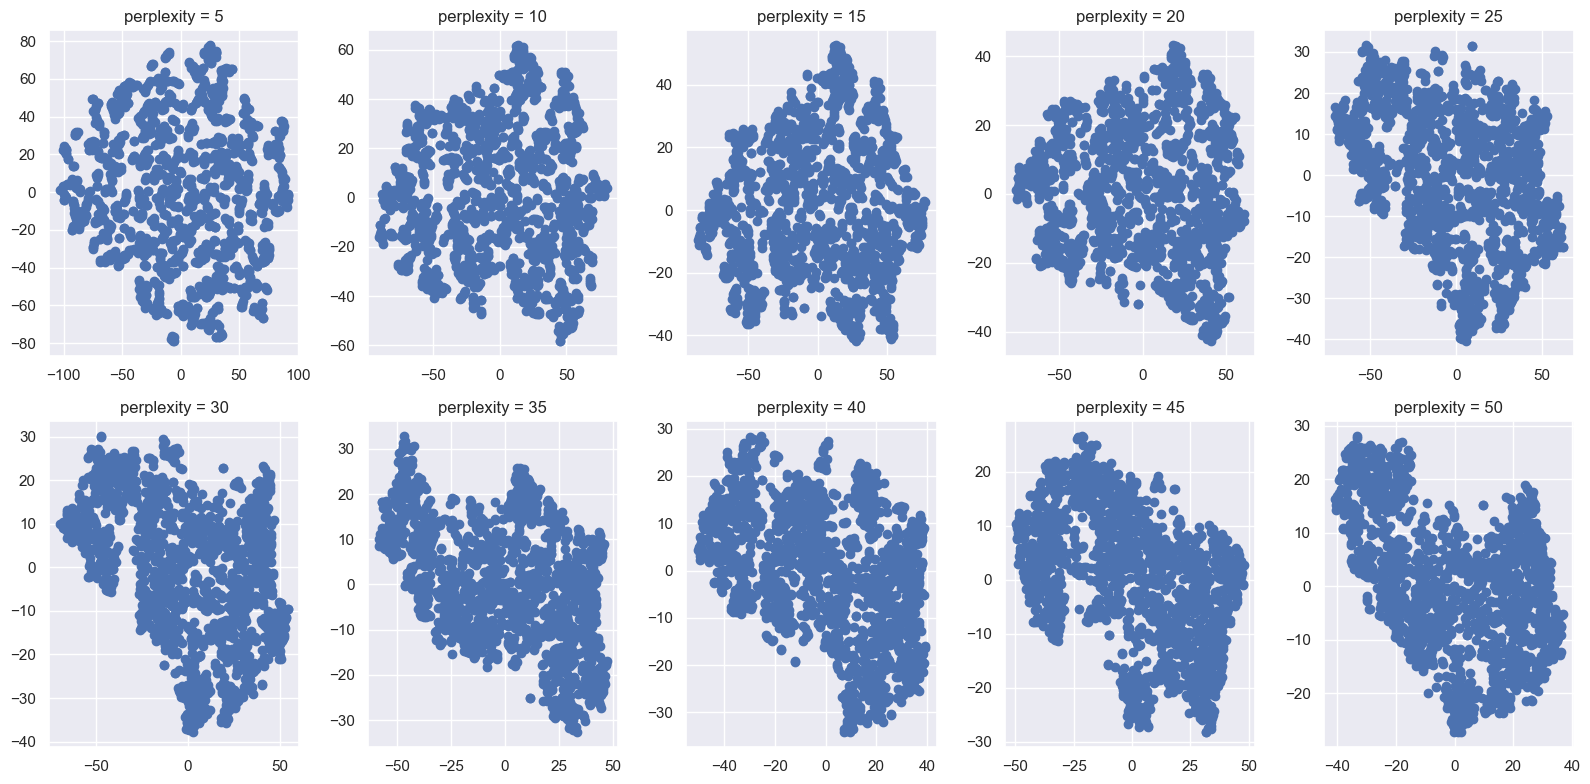

In [55]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, 
#                 early_exaggeration=4,
                init='random',
                random_state=42)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [56]:
perplexity = 25
tsne = TSNE(perplexity=perplexity, 
#             early_exaggeration=4,
            init='random',
            random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

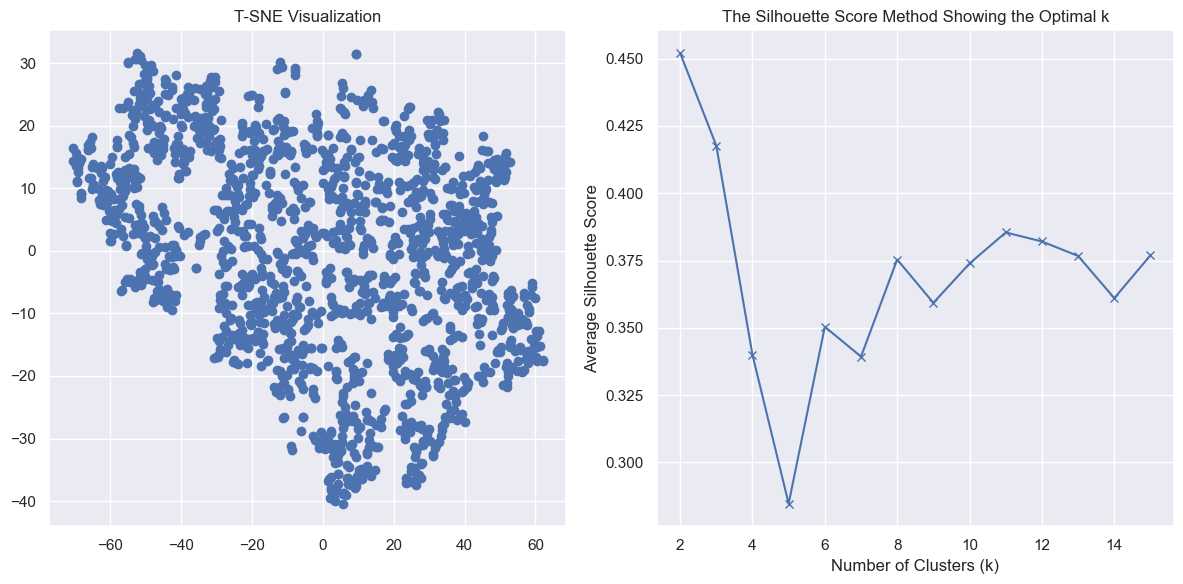

In [57]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [58]:
upper_limit = 40
lower_limit = -80
loc = 'lower left'

Text(0.5, 1.0, 'Spectral Clustering based on 9 PCA features')

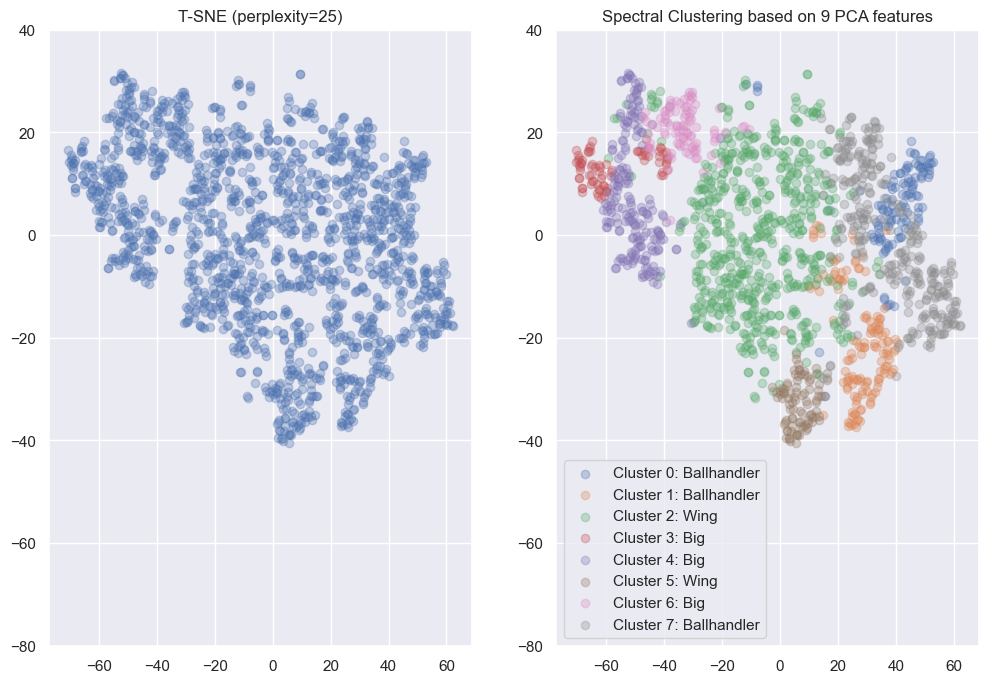

In [59]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

In [60]:
df_tsne = df.copy()
n_clusters_tsne = 3

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

Text(0.5, 1.0, 'Spectral Clustering based on 9 PCA features')

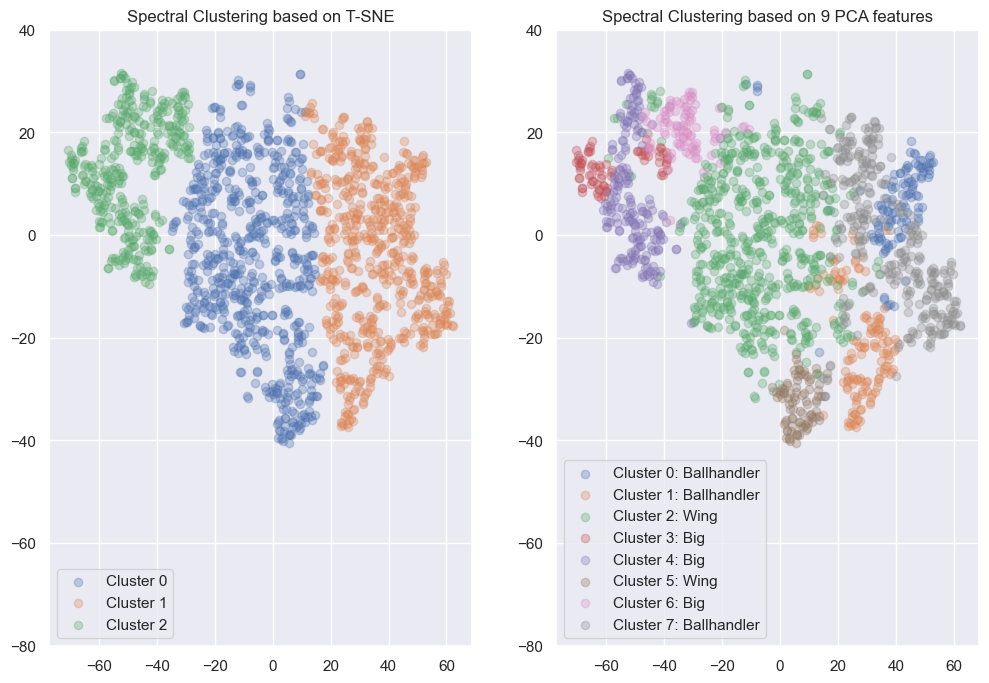

In [61]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')